In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models, datasets
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [8]:
import gc
import torch

torch.cuda.empty_cache()
gc.collect()

0

# Data Preperation

In [21]:
data = pd.read_csv('HAM10000_metadata_paths.csv')
mapping = {'bkl': 0, 'nv': 1, 'df': 2, 'mel': 3, 'bcc': 4, 'akiec': 5, 'vasc': 6}
X = data['image_path']
y = data['dx'].map(mapping)
print(y)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.5, random_state=42)


class HAM(Dataset):
    def __init__(self, X, y, transform=None):
        self.X = X.reset_index(drop=True)
        self.y = y.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        img_path = self.X[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.y[idx]
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label)
        return image, label

transform = transforms.Compose([
    transforms.Resize((300, 300)),
    transforms.ToTensor(),
])

train_dataset = HAM(X_train, y_train, transform=transform)
val_dataset = HAM(X_val, y_val, transform=transform)
test_dataset = HAM(X_test, y_test, transform=transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

0        0
1        0
2        0
3        0
4        0
        ..
10010    5
10011    5
10012    5
10013    5
10014    3
Name: dx, Length: 10015, dtype: int64


In [22]:
model = models.inception_v3(pretrained = True)
model

c:\Users\adity\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\adity\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [23]:
# Lets freeze all layers and change just a few layers to match our requirements

for param in model.parameters():
    param.requires_grad = False #This does the freezing in the model (You freeze the weights and only use the last layer!)
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
model.fc = nn.Sequential(nn.Flatten(), nn.Linear(2048, 128),nn.ReLU(), nn.Dropout(0.1), nn.Linear(128, 7))
model.aux_logits = False
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 1e-3)
model.to(device='cuda')

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [24]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []
device = 'cuda'
loss_fn = nn.CrossEntropyLoss()
def train(train_loader, val_loader, epochs = 20):
    for epoch in range(epochs):
        model.train()
        train_loss, correct = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
        train_loss /= len(train_loader.dataset)
        train_accuracy = correct / len(train_loader.dataset)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)
        
        model.eval() 
        val_loss, correct = 0, 0
        with torch.no_grad(): 
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = correct / len(val_loader.dataset)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
        
    # torch.save(model.state_dict(), 'inception_model.pth')
    torch.save(model, 'inception_model.pth')

In [25]:
train(train_loader, val_loader, epochs=20)
print(f'Training Losses: {train_losses}')
print(f'Training Accuracies: {train_accuracies}')
print(f'Validation Losses: {val_losses}')
print(f'Validation Accuracies: {val_accuracies}')

Epoch 1: Train Loss: 0.0301, Train Accuracy: 0.6804, Val Loss: 0.0278, Val Accuracy: 0.6973
Epoch 2: Train Loss: 0.0265, Train Accuracy: 0.7077, Val Loss: 0.0259, Val Accuracy: 0.7193
Epoch 3: Train Loss: 0.0254, Train Accuracy: 0.7132, Val Loss: 0.0255, Val Accuracy: 0.7313
Epoch 4: Train Loss: 0.0248, Train Accuracy: 0.7185, Val Loss: 0.0254, Val Accuracy: 0.7283
Epoch 5: Train Loss: 0.0247, Train Accuracy: 0.7159, Val Loss: 0.0248, Val Accuracy: 0.7233
Epoch 6: Train Loss: 0.0240, Train Accuracy: 0.7209, Val Loss: 0.0243, Val Accuracy: 0.7373
Epoch 7: Train Loss: 0.0235, Train Accuracy: 0.7274, Val Loss: 0.0239, Val Accuracy: 0.7293
Epoch 8: Train Loss: 0.0234, Train Accuracy: 0.7275, Val Loss: 0.0246, Val Accuracy: 0.7263
Epoch 9: Train Loss: 0.0232, Train Accuracy: 0.7313, Val Loss: 0.0241, Val Accuracy: 0.7383
Epoch 10: Train Loss: 0.0230, Train Accuracy: 0.7338, Val Loss: 0.0245, Val Accuracy: 0.7383
Epoch 11: Train Loss: 0.0229, Train Accuracy: 0.7399, Val Loss: 0.0240, Val Acc

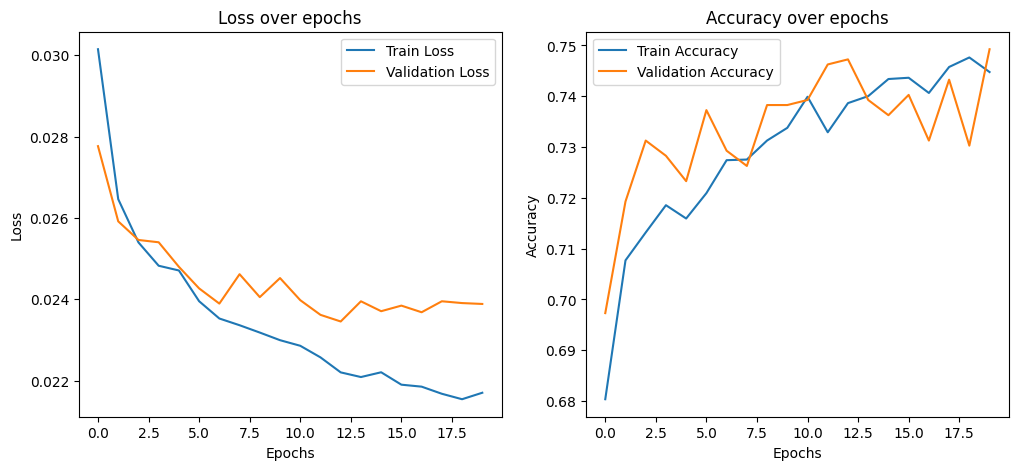

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [132]:
model.load_state_dict(torch.load('inception_model.pth'))
model.to(device)
model.eval()  
test_losses, test_accuracies = [], []

correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        loss = loss_fn(outputs, labels)
        test_losses.append(loss.item())

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 1.0000


Test Accuracy: 1.0000
Predicted: "1", Actual: "1"


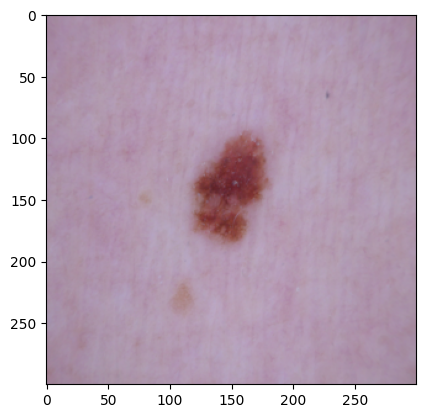

In [146]:
import torchvision.transforms as transforms
from PIL import Image

model = models.inception_v3(pretrained = True)
for param in model.parameters():
    param.requires_grad = False 
model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
model.fc = nn.Sequential(nn.Flatten(), nn.Linear(2048, 128),nn.ReLU(), nn.Dropout(0.1), nn.Linear(128, 5))
model.aux_logits = False
model.load_state_dict(torch.load('inception_model.pth'))
model.to(device)
model.eval()  

def evaluate_accuracy(test_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Test Accuracy: {correct / total:.4f}')

evaluate_accuracy(test_loader)

import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image

def imshow(img):
    img = img.cpu().numpy().transpose((1, 2, 0)) 
    plt.imshow(img)
    plt.show()

def predict_random_image(test_loader):
    model.eval() 
    images, labels = next(iter(test_loader))
    images, labels = images.to(device), labels.to(device)
    output = model(images)
    _, predicted = torch.max(output, 1)
    print(f'Predicted: "{predicted[0].item()}", Actual: "{labels[0].item()}"')
    img = transforms.ToPILImage()(images[0].cpu())
    plt.imshow(img)
    plt.show()

predict_random_image(test_loader)